In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm import tqdm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(json.__version__)
print(re.__version__)
print(np.__version__)
print(pd.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
2.0.9
2.2.1
1.21.4
1.3.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [1]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

print(vocab_list)

In [3]:
file_path = os.path.join(data_dir, 'kowiki.txt')

# 파일 열기
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            print(line.strip())  # 한 줄씩 출력
            if i >= 15:  # 처음 10줄만 출력
                break
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"파일을 여는 중 오류 발생: {e}")

지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧을 내세웠다.
지미 카터는 대한민국과의 관계에서도 중요한 영향을 미쳤던 대통

In [4]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
# CLS : 요약 , SEP : 문장 경계
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


In [5]:
# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

10

In [5]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 
    cand_idx = []  # word 단위의 index array
    for i, token in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    # tokens를 복사하여 변경할 준비
    masked_tokens = copy.deepcopy(tokens)
    mask_lms = []

    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            if len(mask_lms) >= mask_cnt:
                break

            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9:  # 10% keep original
                masked_token = masked_tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)

            mask_lms.append({"index": index, "label": tokens[index]})
            masked_tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return masked_tokens, mask_idx, mask_label

In [7]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '[MASK]', '▁삼', '십', '▁전', '▁둘째', '번', '[MASK]', '[MASK]', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁그레이트', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘러', '[MASK]', '[MASK]', '[MASK]', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

mask_idx   : [18, 24, 2

In [8]:
string = """제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다."""

In [9]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
for tokens in doc:
    print(tokens)

['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '번째', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁지미', '▁카', '터는', '▁조지아', '주', '▁섬', '터', '▁카운티', '▁플', '레인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과', '대학교를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군에', '▁들어가', '▁전함', '·', '원자', '력', '·', '잠', '수', '함의', '▁승무', '원으로', '▁일하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대', '위로', '▁예편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.']
['▁1962', '년', '▁조지아', '▁주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지', '사를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아', '주', '▁상원의', '원을', '▁두', '번'

In [10]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [6]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [7]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    :param vocab: SentencePieceProcessor
    :param doc: 줄 단위로 토큰화된 문서
    :param n_seq: 최대 시퀀스 길이
    :param mask_prob: 마스킹 확률
    :param vocab_list: 랜덤 토큰 생성용 vocab 리스트
    :return: pretrain 인스턴스 리스트
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3  

    instances = []
    current_chunk = [] # line 단위 tokens
    current_length = 0

    for i in range(len(doc)): # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # # current_chunk의 token 수

        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄이거나 길이가 max_seq 이상인 경우
            
            # token a 
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])

            # token b 
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_a, tokens_b = tokens_b, tokens_a
            else:
                is_next = 1    # True

            # max_seq보다 큰 경우 길이 조절
            while len(tokens_a) + len(tokens_b) > max_seq:
                if len(tokens_a) > len(tokens_b):
                    tokens_a.pop(0)
                else:
                    tokens_b.pop()

            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0

    return instances

### seq1,seq2,seq3 -> seq1,seq2과 seq2,seq3 처럼 슬라이딩 방식으로 오게 해야 더 성능이 좋지 않을까?
    * MASK가 유출될 가능성 때문에 안 될 것 같다.

In [13]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '[MASK]', '▁미국', '▁주어진', '▁Sw', '▁대통령', '▁(19', '77', '년', '[MASK]', '▁1981', '년', ')', '이다', '.', '[SEP]', '[MASK]', '▁카', '터는', '▁조지아', '주', '▁섬', '터', '▁카운티', '▁플', '레인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과', '대학교를', '▁졸업하였다', '.', '▁그', '▁후', '[MASK]', '▁들어가', '▁전함', '·', '원자', '력', '·', '잠', '수', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [18, 20, 21, 23, 24, 25, 26, 33, 54], 'mask_label': ['▁출신', '▁39', '번째', '▁(19', '77', '년', '▁~', '▁지미', '▁해군에']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁조지아', '▁주', '▁지', '사를', '▁역임했다', '.', '▁대통령이', '▁되기', '[MASK]', '▁조지아', '주', '▁상원의', '원을', '▁두', '번', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁1971', '년부터', '▁1975', '년

In [14]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [2]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)  
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line)    
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

In [16]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁결정', '학', '▁등이', '▁개발되어', '▁유기', '▁화합물', '▁분석', '에', '▁있어서', '▁매우', '▁중요한', '▁방법으로', '▁자리잡았다', '.', '▁플라스틱', ',', '▁합성', '섬유', '등의', '[MASK]', '[MASK]', '[MASK]', '▁등도', '▁유기', '화', '학에서', '▁다루', '어진다', '.', '[SEP]', '▁유기', '화', '학은', '▁탄', '소로', '▁이루어진', '▁화합', '물을', '[MASK]', '▁분', '과', '이다', '.', '▁원래', '▁유기', '▁화합', '물은', '▁식물', '이나', '▁동물', '로부터', '▁추출', '해', '낸', '▁화합', '물을', '▁뜻', '하였으나', '[MASK]', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [1, 2, 5, 22, 23, 24, 41, 61, 62], 'mask_label': ['▁X', '선', '▁등이', '▁고분', '자', '물질', '▁연구하는', '▁지금은', '▁유기']}
{'tokens': ['[CLS]', '▁X', '선', '▁결정', '학', '▁등이', '▁개발되어', '▁유기', '▁화합물', '[MASK]', '[MASK]', '▁있어서', '▁매우', '▁중요한', '▁방법으로', '▁자리잡았다', '.', '▁플라스틱', ',', '▁합성', '

  0%|          | 0/3957761 [00:00<?, ?it/s]

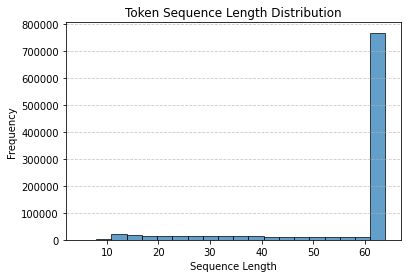

In [22]:
seq_lengths = []  # 시퀀스 길이를 저장할 리스트

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # 빈 줄로 새로운 단락 구분
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # 각 instance의 토큰 길이를 저장
                seq_lengths.extend([len(instance['tokens']) for instance in instances])
                doc = []
        else:  # 빈 줄이 아닌 경우
            pieces = vocab.encode_as_pieces(line)  # 토크나이즈
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막 남은 문단 처리
        instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
        seq_lengths.extend([len(instance['tokens']) for instance in instances])

# 시퀀스 길이 분포 시각화
plt.hist(seq_lengths, bins=20, edgecolor='k', alpha=0.7)
plt.title("Token Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

* 두 개의 sequence를 이어내야하니까 토큰 128은 적절한 값으로 보임

In [8]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    # instances
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

* 문단 단위로 인스턴스 생성 
* 두 문장을 SEP로 이어붙임 400만개 -> 200만개
* 한 문장만 존재하는 문단은 탈락 & 128 token을 넘어가는 문단 탈락 200만개 -> 86만개 

In [21]:
# VOCAB 32000짜리로 잘 전처리된 corpus json data

json_file_path = os.path.join(os.getenv('HOME'), 'aiffel/bert_pretrain/data/bert_pre_train.json')

data = []

try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # \n 으로 객체 구별
            instance = json.loads(line.strip())
            data.append(instance)

    print(f"total data: {len(data)}")
    for i, instance in enumerate(data[:2]):  # 첫 2개 출력
        print(f"Instance {i+1}:")
        print(json.dumps(instance, ensure_ascii=False, indent=4))
        print("\n")
except json.JSONDecodeError as e:
    print(f"JSONDecodeError: {e}")
except Exception as e:
    print(f"Another Error: {e}")

total data: 862285
Instance 1:
{
    "tokens": [
        "[CLS]",
        "▁태어났다",
        ".",
        "▁조지아",
        "▁공과",
        "대학교를",
        "▁졸업하였다",
        ".",
        "▁그",
        "[MASK]",
        "▁해군에",
        "▁들어가",
        "▁전함",
        "·",
        "원자",
        "력",
        "·",
        "잠",
        "수",
        "함의",
        "▁승무",
        "원으로",
        "▁일하였다",
        ".",
        "▁1953",
        "년",
        "▁미국",
        "▁해군",
        "▁대",
        "위로",
        "▁예편",
        "하였고",
        "▁이후",
        "▁땅",
        "콩",
        "·",
        "면",
        "화",
        "▁등을",
        "▁가",
        "꿔",
        "▁많은",
        "▁돈을",
        "▁벌",
        "었다",
        ".",
        "▁그의",
        "▁별명이",
        "[MASK]",
        "[MASK]",
        "[MASK]",
        "▁농부",
        "\"",
        "▁(",
        "P",
        "ean",
        "ut",
        "[MASK]",
        "[MASK]",
        "[MASK]",
        "[MASK]",
        "[MASK]",
        "▁알려졌다",
     

In [23]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [24]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

862285

In [26]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [27]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/862285 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '▁지미', '[MASK]', '[SEP]', '▁제임스', '▁얼', '▁"', '지', '미', '"', '[MASK]', '▁주니어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '번째', '▁대통령', '▁와인', '▁용어이다', '▁이것이', '▁~', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁지미', '▁카', '터는', '▁조지아', '주', '▁섬', '터', '▁카운티', '▁플', '레인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '[MASK]', '[MASK]', '▁졸업하였다', '.', '[MASK]', '▁후', '▁해군에', '[MASK]', '▁전함', '·', '원자', '력', '·', '잠', '수', '함의', '▁승무', '원으로', '▁일하였다', '.', '▁1953', '년', '▁미국', '[MASK]', '▁대', '위로', '▁예편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아', '▁주', '[MASK]', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거가', '▁부정', '선거', '[MASK]', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_39/767648317.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_39/767648317.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

In [9]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [29]:
# 256000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=256000)

  0%|          | 0/256000 [00:00<?, ?it/s]

/tmp/ipykernel_39/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_39/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

data load early stop 256000 256000


#### 학습 시 메모리 4G만 씀 

In [10]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [11]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [12]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [13]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [14]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [15]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [16]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and linear
        attn_out = tf.transpose(attn_out, [0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out, [batch_size, -1, self.d_model])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out)  # (bs, Q_len, d_model)

        return attn_out

In [18]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [20]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [21]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [22]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [23]:
config = Config({
    "d_model": 256,
    "n_head": 8, 
    "d_head": 32,  # d_model / n_head 
    "dropout": 0.1,
    "d_ff": 1024,
    "layernorm_epsilon": 0.001,
    "n_layer": 12, 
    "n_seq": 256, 
    "n_vocab": 0, 
    "i_pad": 0 
})

config.n_vocab = len(vocab) 
config.i_pad = vocab.pad_id() 
config

{'d_model': 256,
 'n_head': 8,
 'd_head': 32,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 12,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

In [45]:
# 모델 동작 확인
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 34s 29ms/step - loss: 11.2070 - nsp_loss: 0.7707 - mlm_loss: 10.4363 - nsp_acc: 0.3000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 9.8725 - nsp_loss: 0.6784 - mlm_loss: 9.1941 - nsp_acc: 0.6000 - mlm_acc: 0.2900


In [24]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [25]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [26]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

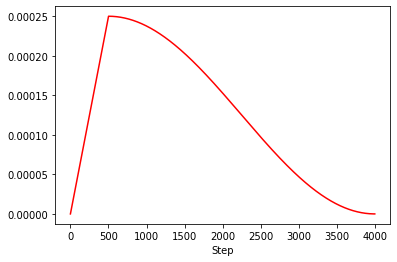

In [27]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [28]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 17737472    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                   

In [51]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 40000


In [52]:
# Q. 모델을 학습시키고, 내용을 history에 담아주세요.
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(
    pre_train_inputs,
    pre_train_labels,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights],
    verbose=1
)

Epoch 1/10
4000/4000 [==============================] - 2041s 508ms/step - loss: 21.5219 - nsp_loss: 0.6173 - mlm_loss: 20.9046 - nsp_acc: 0.6361 - mlm_lm_acc: 0.0951

Epoch 00001: mlm_lm_acc improved from -inf to 0.09514, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
4000/4000 [==============================] - 2037s 509ms/step - loss: 17.8396 - nsp_loss: 0.5812 - mlm_loss: 17.2585 - nsp_acc: 0.6750 - mlm_lm_acc: 0.1566

Epoch 00002: mlm_lm_acc improved from 0.09514 to 0.15664, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
4000/4000 [==============================] - 2039s 510ms/step - loss: 14.8282 - nsp_loss: 0.5699 - mlm_loss: 14.2583 - nsp_acc: 0.6953 - mlm_lm_acc: 0.2198

Epoch 00003: mlm_lm_acc improved from 0.15664 to 0.21984, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
4000/4000 [==============================] - 2039s 510ms/step - loss: 13.5201 - nsp_loss: 0.5591 -

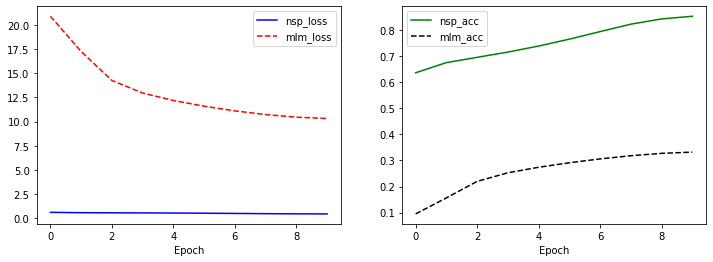

In [53]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### 정성평가

In [62]:
# 모델불러오기 
pre_train_model.load_weights(f"{model_dir}/bert_pre_train.hdf5")

# EX
sentences = [
    "오바마는 미국의 [MASK] 선거에 출마했다.",
    "계산 실력은 [MASK]적 사고력과 관련이 없다.",
    "물 [MASK]는 하나의 산소와 두 개의 수소 [MASK]로 이루어져 있다."
]

# bert에 맞는토큰화 함수 
def tokenize_sentences(sentences, vocab, max_len):
    tokenized_data = []
    for sentence in sentences:
        tokens = ["[CLS]"] + vocab.encode_as_pieces(sentence) + ["[SEP]"]
        segments = [0] * len(tokens)
        # 패딩 처리
        tokens += ["[PAD]"] * (max_len - len(tokens))
        segments += [0] * (max_len - len(segments))
        tokenized_data.append((tokens, segments))
    return tokenized_data

# MAX_LEN
max_len = config.n_seq

# 토큰화 
tokenized_data = tokenize_sentences(sentences, vocab, max_len)

results = []

for tokens, segments in tokenized_data:
    enc_tokens = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * len(enc_tokens)
    
    # 배열 변환 
    enc_tokens_array = np.array([enc_tokens])
    segments_array = np.array([segments])
    
    # predict
    logits_cls, logits_lm = pre_train_model.predict((enc_tokens_array, segments_array))
    
    # [MASK] indices
    mask_indices = [idx for idx, token in enumerate(tokens) if token == "[MASK]"]
    
    # [MASK] token 예측 
    predicted_tokens = []
    for mask_idx in mask_indices:
        predicted_token_id = int(np.argmax(logits_lm[0, mask_idx]))
        predicted_token = vocab.id_to_piece(predicted_token_id)
        predicted_tokens.append(predicted_token)
    
    generated_sentence = tokens.copy()
    for mask_idx, predicted_token in zip(mask_indices, predicted_tokens):
        generated_sentence[mask_idx] = predicted_token
    
    results.append({
        "original_sentence": "".join(tokens).replace("[PAD]", ""),
        "predicted_tokens": predicted_tokens,
        "generated_sentence": "".join(generated_sentence).replace("[PAD]", "")
    })

In [63]:

for result in results:
    print("Original Sentence:", result["original_sentence"])
    print("Predicted Tokens for [MASK]:", result["predicted_tokens"])
    print("Generated Sentence:", result["generated_sentence"])
    print("-" * 50)

Original Sentence: [CLS]▁오바마는▁미국의▁[MASK]▁선거에▁출마했다.[SEP]
Predicted Tokens for [MASK]: ['▁대통령']
Generated Sentence: [CLS]▁오바마는▁미국의▁▁대통령▁선거에▁출마했다.[SEP]
--------------------------------------------------
Original Sentence: [CLS]▁계산▁실력은▁[MASK]적▁사고력과▁관련이▁없다.[SEP]
Predicted Tokens for [MASK]: ['▁의']
Generated Sentence: [CLS]▁계산▁실력은▁▁의적▁사고력과▁관련이▁없다.[SEP]
--------------------------------------------------
Original Sentence: [CLS]▁물▁[MASK]는▁하나의▁산소와▁두▁개의▁수소▁[MASK]로▁이루어져▁있다.[SEP]
Predicted Tokens for [MASK]: ['▁물', '▁']
Generated Sentence: [CLS]▁물▁▁물는▁하나의▁산소와▁두▁개의▁수소▁▁로▁이루어져▁있다.[SEP]
--------------------------------------------------


* bert 임베딩을 통해서 직접 분류나 다른 task에 집어넣어보고 싶었으나 시간이 부족했다. 
* 사실은 hugging face에서 받아온 kobert의 성능보다야 당연 저조할게 뻔하니 의욕도 부족했다. 
    * 차라리 hugging face에서 받아온 kobert의 구조나 pretrain에 사용된 데이터의 수준을 보는게 더 배울점이 있을 것 같다.
* 문단 두 개를 이어붙여서 학습한다는 것과 [MASK]를 맞춘다는 개념으로 모델을 구축하다보니 생소한 점이 좀 있었던 것 같다. 
* 결과적으로 context의 정보를 얼마나 잘 포함시키느냐-가 관건
* GPT를 사용하는 입장에서 이 부분에서 GPT를 능가하는 모델은 아직 없는 것 같다.